# 0. Project Goal

The goal is to predict which previously purchased products will be in a user's next order using Instacart's transactional data.

# 1. Importing data & relevant libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
#from ydata_profiling import ProfileReport

In [4]:
# Load each data file into a pandas DataFrame
aisles = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')

# 2. Preliminary data exploration

In [3]:
# List of DataFrames for iteration
dataframes = {'Aisles': aisles, 'Departments': departments, 'Order_Products_Prior': order_products_prior, 
              'Order_Products_Train': order_products_train, 'Orders': orders, 'Products': products}

# Function to print attribute details with additional statistics
def attribute_details(df_name, df):
    print(f"\nDataFrame: {df_name}")
    print(f"{'Attribute':<25} {'Type':<10} {'% Missing Values':<20} {'Min':<10} {'Max':<10} {'Mean/Mode':<15}")
    for col in df.columns:
        pct_missing = df[col].isnull().mean() * 100
        dtype = df[col].dtype
        if df[col].dtype == 'object':  # Categorical data
            try:
                mode = df[col].mode()[0]
            except IndexError:  # Handles empty columns
                mode = "N/A"
            print(f"{col:<25} {str(dtype):<10} {pct_missing:<20.2f} {'N/A':<10} {'N/A':<10} {str(mode):<15}")
        else:  # Numerical data
            min_val = df[col].min()
            max_val = df[col].max()
            mean_val = df[col].mean()
            print(f"{col:<25} {str(dtype):<10} {pct_missing:<20.2f} {str(min_val):<10} {str(max_val):<10} {str(mean_val):<15}")

# Iterating through each DataFrame and printing attribute details with additional statistics
for name, df in dataframes.items():
    attribute_details(name, df)


DataFrame: Aisles
Attribute                 Type       % Missing Values     Min        Max        Mean/Mode      
aisle_id                  int64      0.00                 1          134        67.5           
aisle                     object     0.00                 N/A        N/A        air fresheners candles

DataFrame: Departments
Attribute                 Type       % Missing Values     Min        Max        Mean/Mode      
department_id             int64      0.00                 1          21         11.0           
department                object     0.00                 N/A        N/A        alcohol        

DataFrame: Order_Products_Prior
Attribute                 Type       % Missing Values     Min        Max        Mean/Mode      
order_id                  int64      0.00                 2          3421083    1710748.5189427834
product_id                int64      0.00                 1          49688      25576.337535424096
add_to_cart_order         int64      0.00      

In [4]:
# Combine prior and train order products for full history
order_products = pd.concat([order_products_prior, order_products_train])

# Merge to include product details
merged_data = pd.merge(order_products, products, on='product_id')

# Merge to include order details
merged_data = pd.merge(merged_data, orders, on='order_id')

# Optionally, merge aisles and departments if needed for features
merged_data = pd.merge(merged_data, aisles, on='aisle_id')
merged_data = pd.merge(merged_data, departments, on='department_id')

# Perform data profiling
profile = ProfileReport(merged_data, title="Data Profiling Report", explorative=True)
profile.to_file("data_profiling_report.html")

c:\Users\Yash Joshi\anaconda3\Lib\site-packages\ydata_profiling\profile_report.py:354: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

# 3. Univariate Analysis 

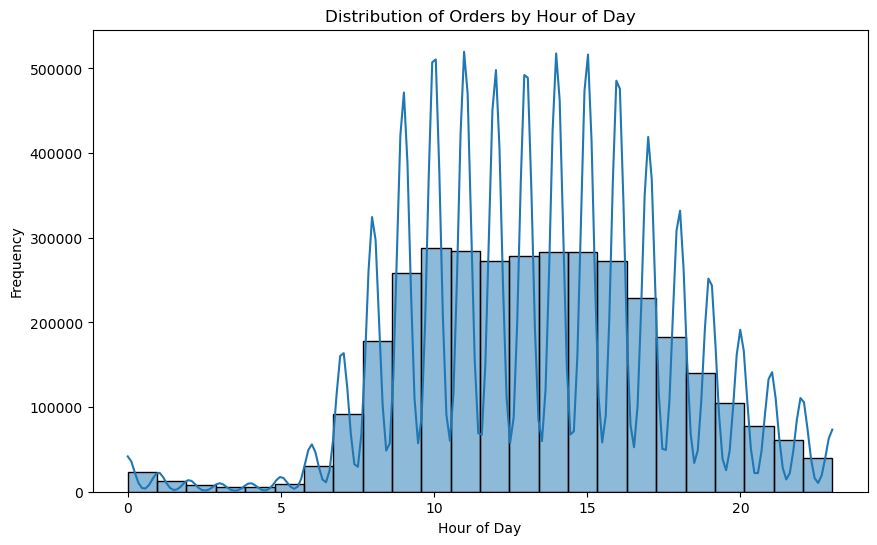

In [4]:
## For 'order_hour_of_day'
plt.figure(figsize=(10, 6))
sns.histplot(orders['order_hour_of_day'], bins=24, kde=True)
plt.title('Distribution of Orders by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

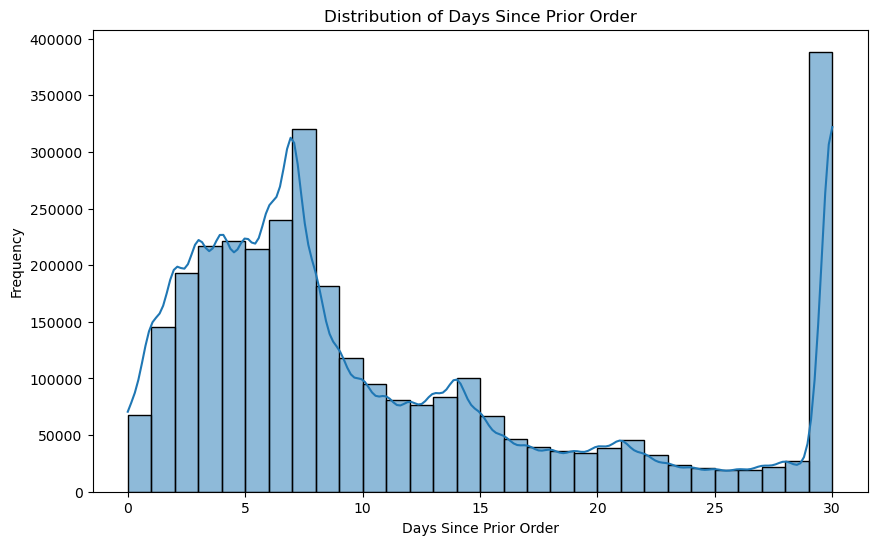

In [5]:
## For 'days_since_prior_order'
plt.figure(figsize=(10, 6))
sns.histplot(orders['days_since_prior_order'].dropna(), bins=30, kde=True)  # Drop NA values for this plot
plt.title('Distribution of Days Since Prior Order')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Frequency')
plt.show()

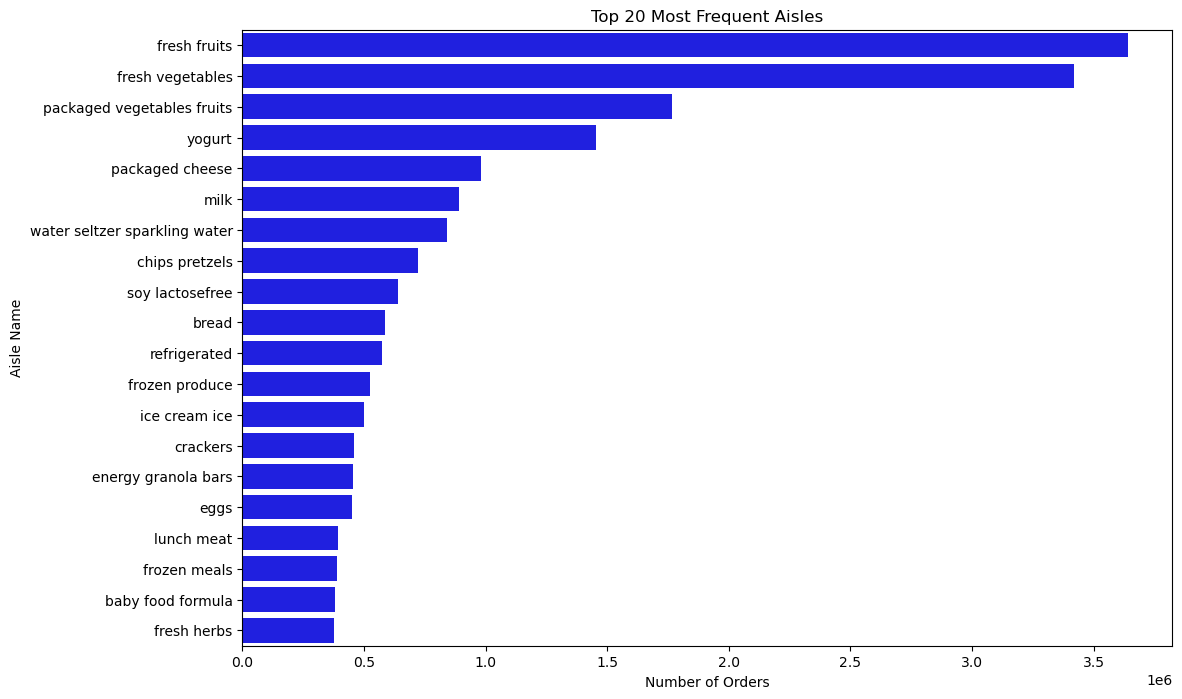

In [6]:
## Merge 'orders' with 'order_products_prior' and then with 'products' to get aisle information for each order
orders_products = orders.merge(order_products_prior, on='order_id').merge(products, on='product_id')

# Merge 'orders_products' with 'aisles' to get aisle names
orders_products_with_aisles = orders_products.merge(aisles, on='aisle_id')

# Count the frequency of each aisle name and pick the top 20
aisle_name_counts = orders_products_with_aisles['aisle'].value_counts().head(20)

# Plotting the top 20 aisles by order frequency
plt.figure(figsize=(12, 8))
sns.barplot(x=aisle_name_counts.values, y=aisle_name_counts.index, orient='h', order=aisle_name_counts.index, color='blue')
plt.title('Top 20 Most Frequent Aisles')
plt.xlabel('Number of Orders')
plt.ylabel('Aisle Name')
plt.show()

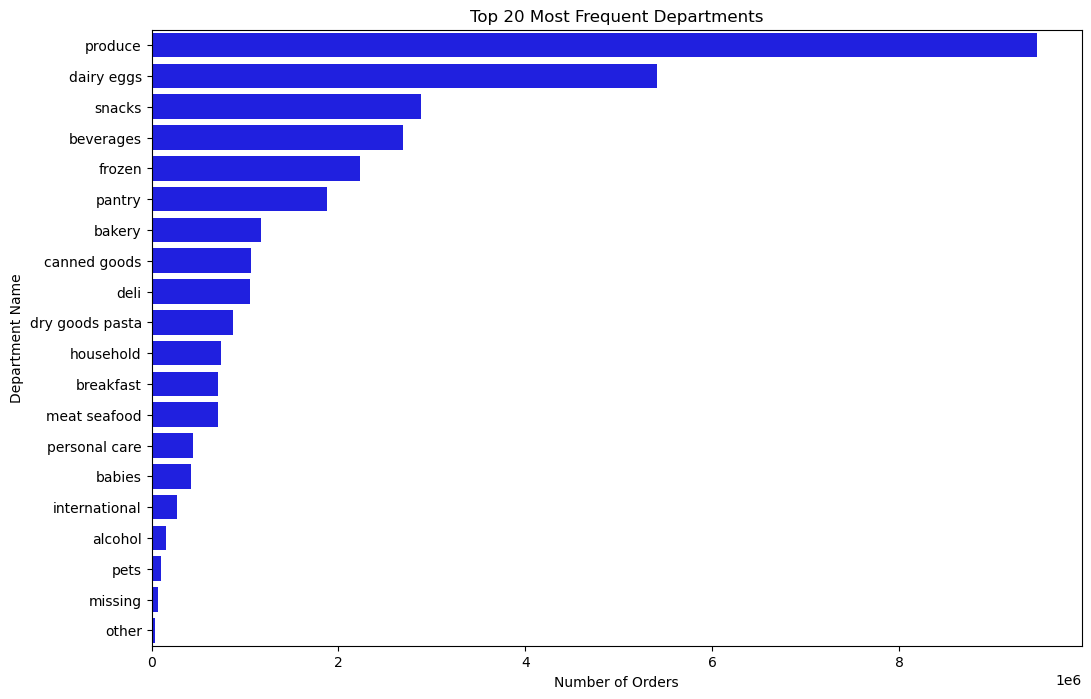

In [7]:
# Merge 'orders_products' with 'departments' to get department names
orders_products_with_departments = orders_products.merge(departments, on='department_id')

# Count the frequency of each department name and select the top 20
department_name_counts = orders_products_with_departments['department'].value_counts().head(20)

# Plotting the top 20 departments by order frequency
plt.figure(figsize=(12, 8))
# The order of departments is determined by 'value_counts', so they are already sorted by the number of orders
sns.barplot(x=department_name_counts.values, y=department_name_counts.index, orient='h', order=department_name_counts.index, color='blue')
plt.title('Top 20 Most Frequent Departments')
plt.xlabel('Number of Orders')
plt.ylabel('Department Name')
plt.show()

# 4. Bi-Variate Analysis

In [8]:
# Combine order_products_prior and order_products_train for full order-product history
order_products_combined = pd.concat([order_products_prior, order_products_train])

# Merge with products, aisles, and departments
order_products_full = pd.merge(order_products_combined, products, on='product_id')
order_products_full = pd.merge(order_products_full, aisles, on='aisle_id')
order_products_full = pd.merge(order_products_full, departments, on='department_id')

# Merge the full order-products information with orders
full_data = pd.merge(order_products_full, orders, on='order_id')

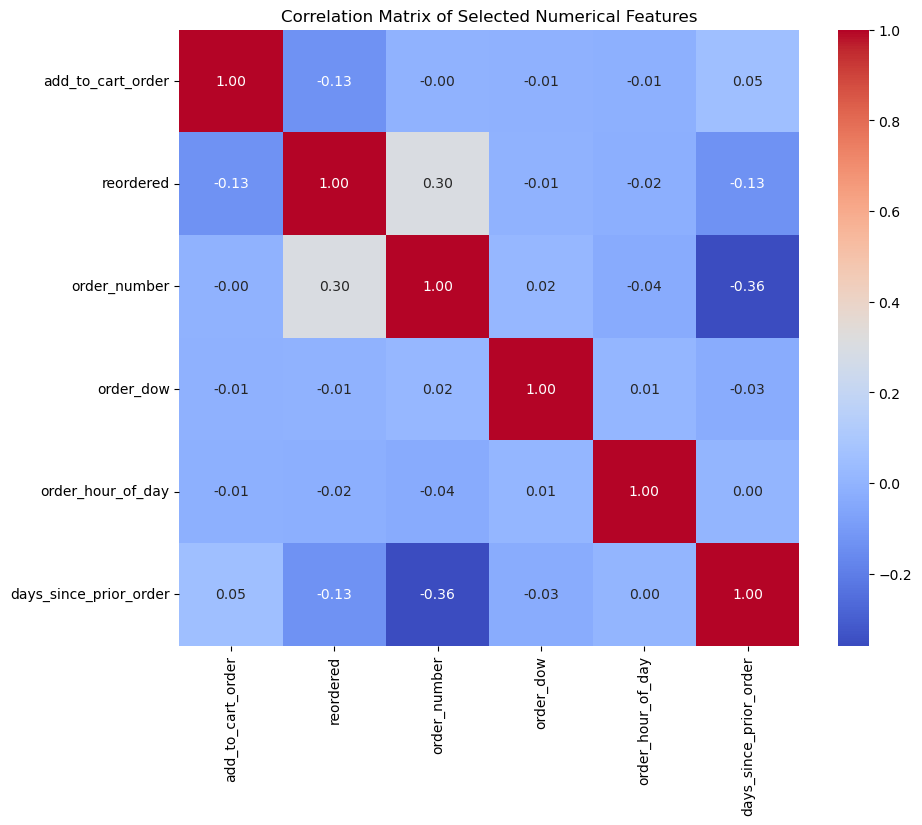

In [9]:
# Select only the relevant numerical columns for correlation analysis
numerical_columns = ['add_to_cart_order', 'reordered', 'order_number', 'order_dow', 
                     'order_hour_of_day', 'days_since_prior_order']

# Filter the full dataset to include only these columns
numerical_data = full_data[numerical_columns]

# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Numerical Features')
plt.show()

# 5. Advanced Visualization

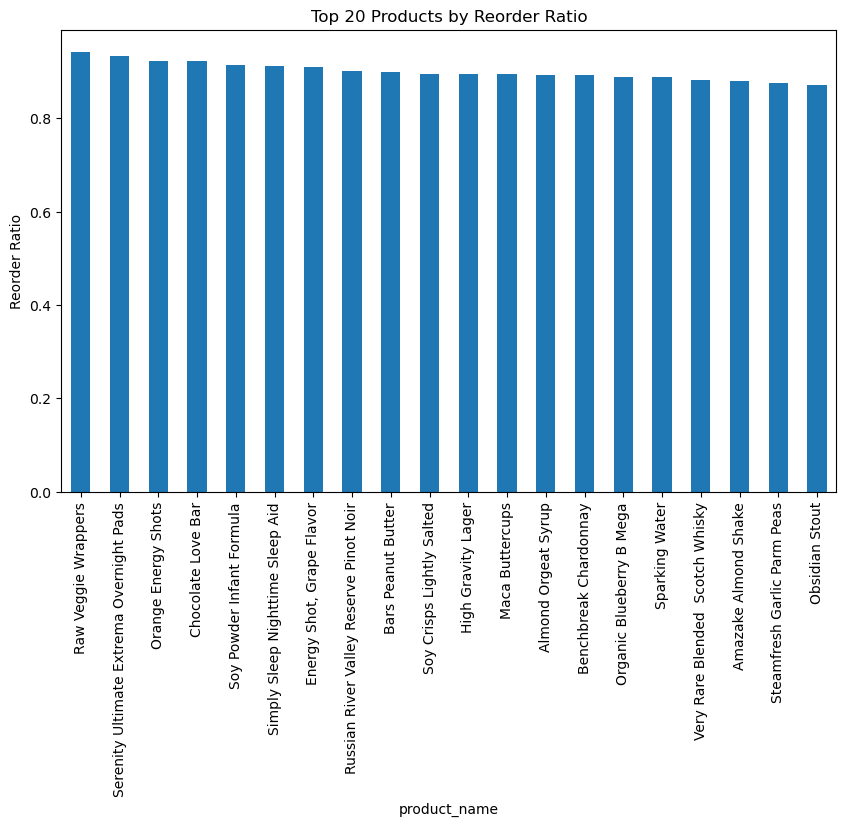

In [10]:
# Reorder Ratio

reorder_ratio = full_data.groupby('product_name')['reordered'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
reorder_ratio.plot(kind='bar')
plt.title('Top 20 Products by Reorder Ratio')
plt.ylabel('Reorder Ratio')
plt.xticks(rotation=90)
plt.show()

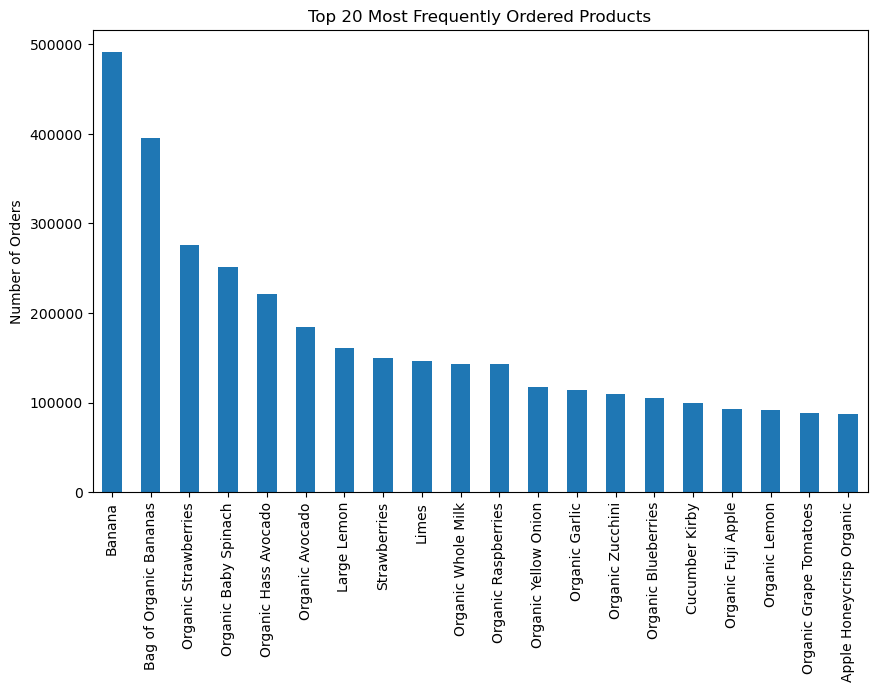

In [11]:
# Product Purchase Frequency

product_frequency = full_data['product_name'].value_counts().head(20)

plt.figure(figsize=(10, 6))
product_frequency.plot(kind='bar')
plt.title('Top 20 Most Frequently Ordered Products')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.show()

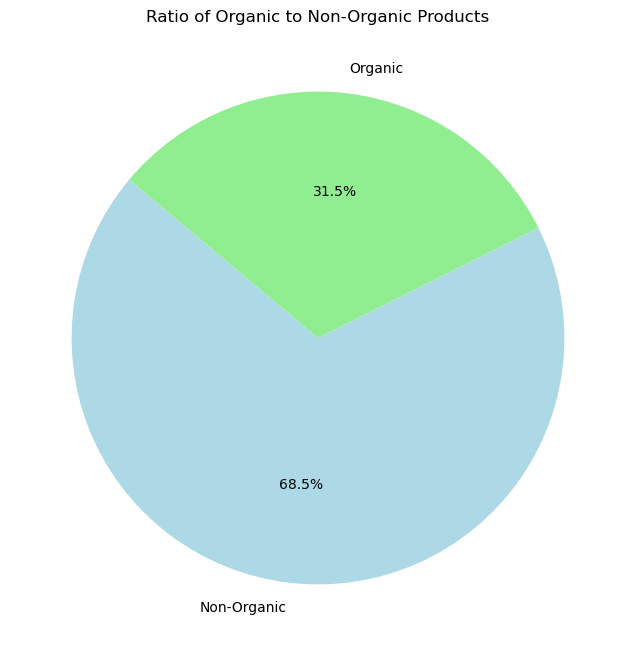

In [12]:
# Organic Product Analysis

# Identifying organic products
full_data['is_organic'] = full_data['product_name'].str.contains('Organic')

# Ratio of organic to non-organic products
organic_ratio = full_data['is_organic'].value_counts(normalize=True)

plt.figure(figsize=(8, 8))
organic_ratio.plot(kind='pie', autopct='%1.1f%%', startangle=140, labels=['Non-Organic', 'Organic'], colors=['lightblue', 'lightgreen'])
plt.title('Ratio of Organic to Non-Organic Products')
plt.ylabel('')
plt.show()

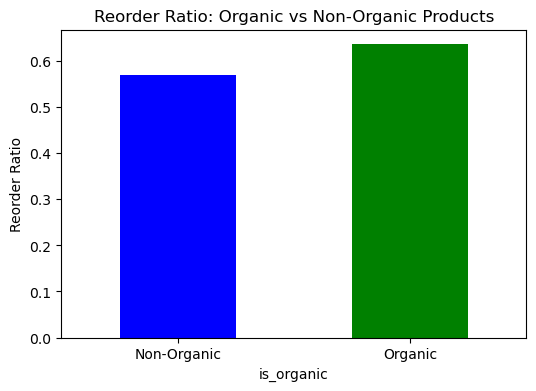

In [13]:
# Reorder ratio for organic vs non-organic products
organic_reorder_ratio = full_data.groupby('is_organic')['reordered'].mean()

plt.figure(figsize=(6, 4))
organic_reorder_ratio.plot(kind='bar', color=['blue', 'green'])
plt.title('Reorder Ratio: Organic vs Non-Organic Products')
plt.ylabel('Reorder Ratio')
plt.xticks(ticks=[0, 1], labels=['Non-Organic', 'Organic'], rotation=0)
plt.show()

In [14]:
# Merge the orders with order products (prior and train) to get the complete dataset
order_products_complete = pd.concat([order_products_prior, order_products_train])
orders_complete = orders.merge(order_products_complete, on="order_id")

# Merge with products to get organic information
orders_products = orders_complete.merge(products, on="product_id")

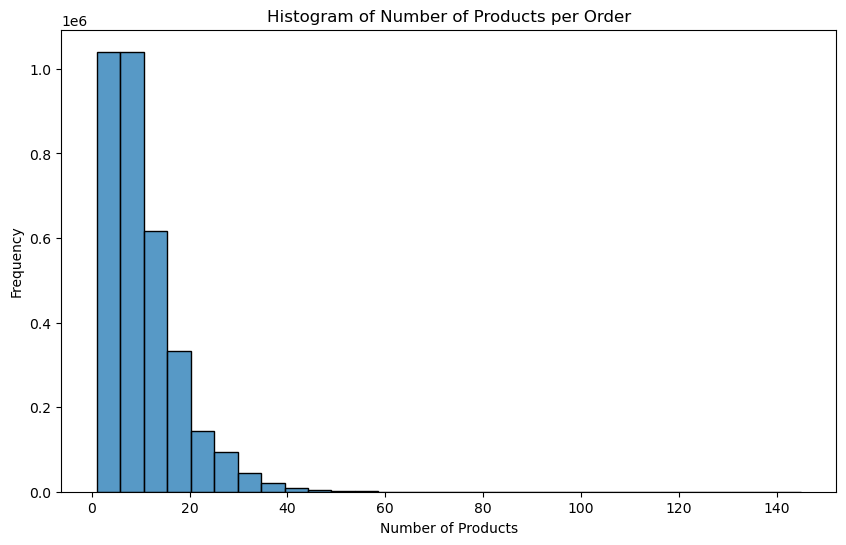

In [15]:
## Histogram of the number of products per order
plt.figure(figsize=(10, 6))
order_counts = orders_complete.groupby("order_id")["product_id"].count()
sns.histplot(order_counts, bins=30, kde=False)
plt.title("Histogram of Number of Products per Order")
plt.xlabel("Number of Products")
plt.ylabel("Frequency")
plt.show()

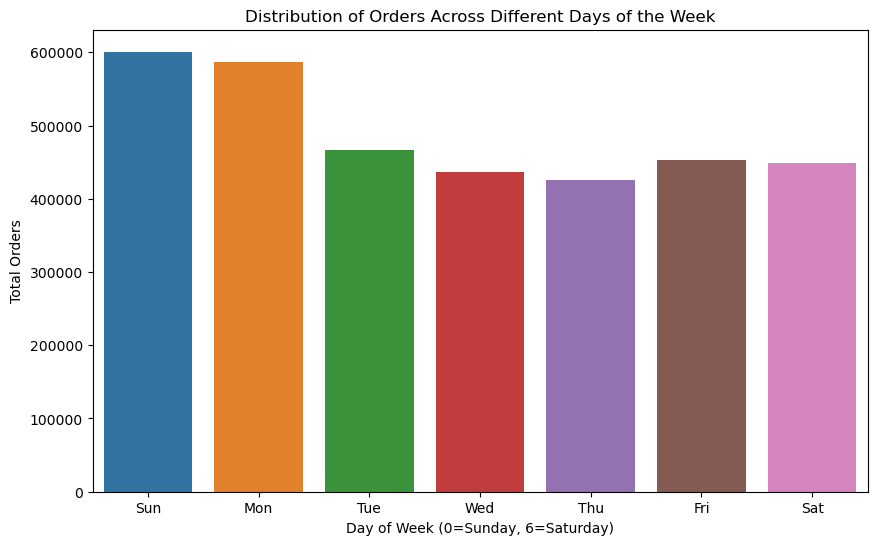

In [16]:
## Bar chart showing the distribution of orders across different days of the week
plt.figure(figsize=(10, 6))
sns.countplot(x="order_dow", data=orders, order=range(0,7))
plt.title("Distribution of Orders Across Different Days of the Week")
plt.xlabel("Day of Week (0=Sunday, 6=Saturday)")
plt.ylabel("Total Orders")
plt.xticks(range(0,7), ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.show()

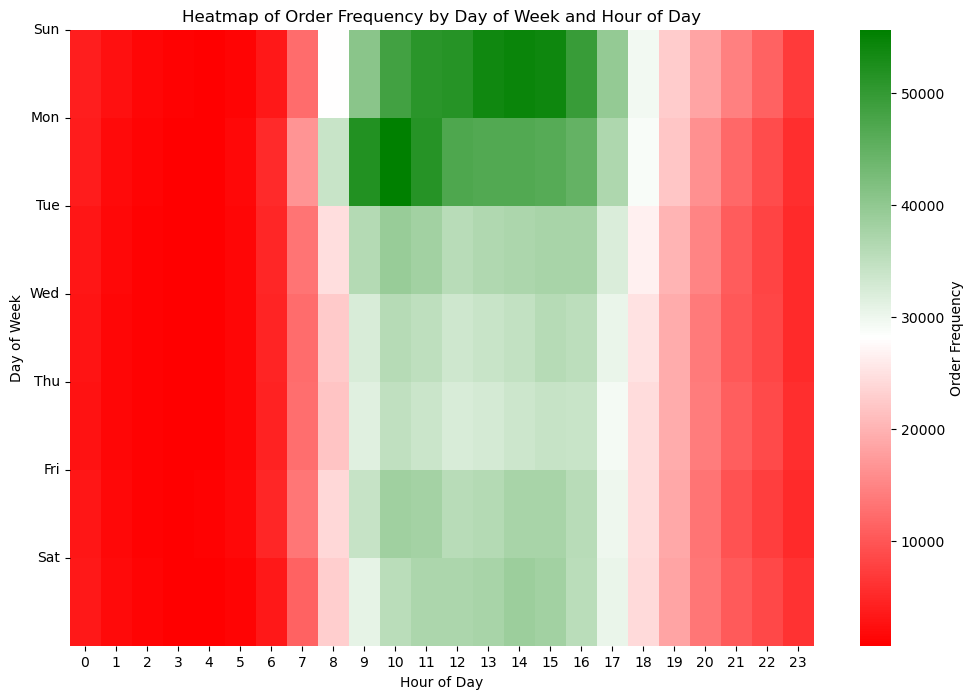

In [17]:
# Temporary Analysis

# Create a pivot table for the heatmap
pivot_table = orders.pivot_table(index='order_dow', columns='order_hour_of_day', values='order_id', aggfunc='count')

# Define a custom colormap from red to white to green
cmap = LinearSegmentedColormap.from_list(
    name='custom_red_white_green',
    colors=['red', 'white', 'green']
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap=cmap, cbar_kws={'label': 'Order Frequency'})
plt.title('Heatmap of Order Frequency by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(ticks=range(0, 7), labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'], rotation=0)
plt.show()

# 6. Train Test Split

In [5]:
# Load datasets
aisles = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')

# Combine prior and train order products for full history
order_products = pd.concat([order_products_prior, order_products_train])

# Merge to include product details
merged_data = pd.merge(order_products, products, on='product_id')

# Merge to include order details
merged_data = pd.merge(merged_data, orders, on='order_id')

# Optionally, merge aisles and departments if needed for features
merged_data = pd.merge(merged_data, aisles, on='aisle_id')
merged_data = pd.merge(merged_data, departments, on='department_id')

# Stratified sampling based on user_id
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(merged_data, merged_data['user_id']): #Stratifying by user_id ensures that each customer's data remains intact within either the training or testing set.
    train_data = merged_data.iloc[train_index]
    test_data = merged_data.iloc[test_index]

# Split the test data into validation and test sets
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Selecting only the user_id and product_id columns for the test data
test_data = test_data[['user_id', 'product_id']]
val_data = val_data[['user_id', 'product_id']]

In [6]:
train_data.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
30724105,455813,30062,10,1,White Select-A-Size Paper Towels,54,17,130900,prior,8,6,8,13.0,paper goods,household
17236289,2002818,13535,2,1,Organic Medium Salsa,51,13,178874,prior,14,4,17,4.0,preserved dips spreads,pantry
11891445,1885773,26209,28,1,Limes,24,4,54782,train,10,0,11,30.0,fresh fruits,produce
9162954,2872961,16759,3,0,Organic Carrot Bunch,83,4,18835,prior,11,5,12,15.0,fresh vegetables,produce
29921489,1797606,38618,6,1,Organic Chunky Vegetable Soup,69,15,1373,prior,13,6,17,6.0,soup broth bouillon,canned goods


In [7]:
val_data.head()

,user_id,product_id
7637587,178683,41950
20119403,183956,42551
15977623,82866,22922
19494024,61288,24561
12376227,148155,13176


In [8]:
test_data.head()

,user_id,product_id
17336791,134451,41527
552968,112031,24838
17370636,171542,2838
27186638,26603,21019
12980711,44920,47209
